# DATA MINING CUP 2020

_Forecasting Demand for Optimized Inventory Planning_

### Scenario

An established retailer wants to optimize its inventory planning to not only significantly
reduce storage space, but also its costs and need for logistical operations. It plans to restock
its inventory every other week and only keep in stock the items that it has actually sold during
that period.

### The goal

Create a machine learning model to predict the
demand for every product over the two-week period.

**Important**

* Some products will be promoted for limited periods of time
* Products that are promoted during the simulation period will be earmarked
* Transaction data needs to indicate whether a product is being promoted during the training period
* To simplify matters, prices will not be changed during the period.
* The teams obtain information about the exact time of every transaction during a period of six months

One file containing the following information should be used to send the solution data:

|    Column name   |             Description            | Data type |
|:----------------:|:----------------------------------:|:---------:|
|      itemID      | Unique identifier for each product |   String  |
| demandPrediction |    Demand prediction for 14 days   |  Integer  |

The key attribute for every prediction is the “itemID”, which can be found in the “items.csv”
file. <br/> A possible extract from the solution file might look like this:

itemID|demandPrediction<br/>
995539|34<br/>
1000002|42<br/>
995554|10<br/>
...<br/>

## Preliminaries & Data Loading

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math
from scipy.stats import binned_statistic
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from pycaret.regression import *

import gc
from datetime import datetime, timedelta
from random import seed
import warnings

seed(42)
warnings.filterwarnings("ignore")
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def change_delimiter(filename, temp=None):
    df = pd.read_csv('DMC-2020-Task/{}.csv'.format(filename))
    if len(df.columns) > 1:
        temp = df.iloc[:,1:]
    col_names = df.columns[0].split('|')
    df = pd.DataFrame(df.iloc[:,0].str.split('|', expand=True))
    df.columns = col_names
    if temp is not None:
        df = pd.concat([df, temp], axis=1)
    return df

In [3]:
infos = change_delimiter('infos')
items = change_delimiter('items')
orders = change_delimiter('orders')

## Problem Understanding 

#### items

Is a master data set that contains descriptive features.<br/>
The features may be categorical or numerical.<br/>
Each data line contains the description for one single item.

|                        |                                                                                                  |                                                                    |
|:----------------------:|:------------------------------------------------------------------------------------------------:|:------------------------------------------------------------------:|
|         itemID         |                                Unique identifier for each product                                |                          Positive integer                          |
|          brand         |             Categorical attribute, different brands are deciphered by integer values             |            [0,..,274] / Positive integer (0 = no brand)            |
| manufacturer           | Categorical attribute, different characteristics are denoted by integers                         | [1,..,253] / Positive integer                                      |
| customerRating         | Numerical attribute, customer rating                                                             | [1,5] / Positive float (0.0 = no customer rating)                  |
| category1              | Categorical and hierarchical attribute                                                           | [1,..,8] / Positive integer                                        |
| category2              | Categorical and hierarchical attribute                                                           | [1,..,52] / Positive integer                                       |
| category3              | Categorical and hierarchical attribute                                                           | [1,..,8] / Positive integer                                        |
| recommendedRetailPrice | Numerical attribute, recommended retail price for a product, mostly provided by the manufacturer | Positive decimal number with two positions after the decimal point |

In [4]:
items

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.0,1,2,1,16.92
2,3,0,3,5.0,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04
...,...,...,...,...,...,...,...,...
10458,10459,180,253,0.0,8,44,8,56.57
10459,10460,0,253,0.0,8,44,8,163.81
10460,10461,0,253,0.0,8,44,8,128.01
10461,10462,180,253,0.0,8,44,8,166.97


In [5]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10463 entries, 0 to 10462
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   itemID                  10463 non-null  object
 1   brand                   10463 non-null  object
 2   manufacturer            10463 non-null  object
 3   customerRating          10463 non-null  object
 4   category1               10463 non-null  object
 5   category2               10463 non-null  object
 6   category3               10463 non-null  object
 7   recommendedRetailPrice  10463 non-null  object
dtypes: object(8)
memory usage: 654.1+ KB


**orders**

File contains every order with its dedicated timestamp for the 6-month period.<br>
Each line displays one transaction for one single item.

|            |                                                                                                                                                                                                                                                                |                                                                    |
|------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------|
| time       | Ordinal attribute, exact time stamp of a product purchase                                                                                                                                                                                                      | YYYY-MM-dd hh:mm:ss                                                |
| transactID | Categorical attribute, ID to connect orders of different products by a single costumer. The ID is not connected to a specific costumer in a fixed way. (i.e. a returning costumer gets every time a different ID). After an period of time an ID can reappear. | Positive integer                                                   |
| itemID     | Unique identifier for every product                                                                                                                                                                                                                            | Positive integer                                                   |
| order      | Numerical attribute, number of sold units of a product in one transaction                                                                                                                                                                                      | Positive integer                                                   |
| salesPrice | Numerical attribute, actual price point of a product                                                                                                                                                                                                           | Positive decimal number with two positions after the decimal point |

In [6]:
orders

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19
...,...,...,...,...,...
2181950,2018-06-29 23:54:22,2040347,9217,1,23.5
2181951,2018-06-29 23:55:09,2260943,2175,1,11.6
2181952,2018-06-29 23:55:09,2260943,2061,1,1.03
2181953,2018-06-29 23:55:09,2260943,2195,1,18.73


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181955 entries, 0 to 2181954
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   time        object
 1   transactID  object
 2   itemID      object
 3   order       object
 4   salesPrice  object
dtypes: object(5)
memory usage: 83.2+ MB


**infos**

File contains a list of all the items, their current sales price as well as the
dates of scheduled promotions during the simulation period.<br>
Every line contains the price and promotion dates for one single item.

|                 |                                                                      |                                                                    |
|-----------------|----------------------------------------------------------------------|--------------------------------------------------------------------|
| itemID          | Unique identifier for every product                                  | Positive integer                                                   |
| simulationPrice | Numerical attribute, the price of a product in the simulation period | Positive decimal number with two positions after the decimal point |
| promotion       | “,” separated list of dates for products in promotion                | Comma-separated list of dates (YYYY-MM-dd)                         |
| promotion_start | The date when the promotion starts                                   | Comma-separated list of dates (YYYY-MM-dd)                         |
| promotion_end   | The date when the promotion ends                                     | Comma-separated list of dates (YYYY-MM-dd)                         |

In [8]:
infos

,itemID,simulationPrice,promotion,promotion_start,promotion_end
0,1,3.43,,NaN,NaN
1,2,9.15,,NaN,NaN
2,3,14.04,,NaN,NaN
3,4,14.1,,NaN,NaN
4,5,7.48,,NaN,NaN
...,...,...,...,...,...
10458,10459,14.71,,NaN,NaN
10459,10460,325.67,,NaN,NaN
10460,10461,190.53,,NaN,NaN
10461,10462,304.3,,NaN,NaN


In [9]:
infos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10463 entries, 0 to 10462
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   itemID           10463 non-null  object
 1   simulationPrice  10463 non-null  object
 2   promotion        10463 non-null  object
 3   promotion_start  190 non-null    object
 4   promotion_end    33 non-null     object
dtypes: object(5)
memory usage: 408.8+ KB


## Exploratory data analysis & Identification

#### Missing values

In [10]:
print('check missing values in items ->', items.isnull().values.any())
print('check missing values in orders ->', orders.isnull().values.any())
print('check missing values in infos ->', infos.isnull().values.any())

check missing values in items -> False
check missing values in orders -> False
check missing values in infos -> True


#### Check for brand, non-brand products number

In [11]:
df = items['brand'].value_counts().reset_index()
df.columns = ['brand', 'number_of_items_produced']
df = df.astype('int')
print(float((df.loc[df['brand'] == 0] / df['number_of_items_produced'].sum())['number_of_items_produced']), 'more than half of products hasn`t got a brand')

0.5000477874414604 more than half of products hasn`t got a brand


#### sum of products produced by the manufacturer

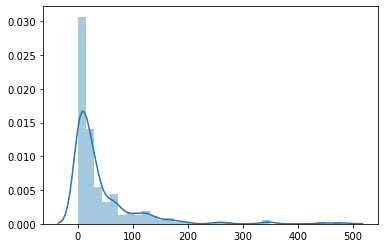

In [12]:
sns.distplot(pd.DataFrame(items['manufacturer'].value_counts()))

#### it turns out that bins here are not effective

In [13]:
pd.DataFrame(binned_statistic(items['manufacturer'].astype('int').unique(),
                 values=items['manufacturer'].value_counts(), statistic= 'mean', bins=3)).loc[2]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
248    3.0
249    3.0
250    3.0
251    3.0
252    3.0
Name: 2, Length: 253, dtype: float64

#### customerRating by the number of customers

In [14]:
df = items['customerRating'].astype('float').round(1)
df = pd.DataFrame(df.value_counts().reset_index())
df.columns = ['score', 'number_of_customers']
df

,score,number_of_customers
0,0.0,7117
1,5.0,2082
2,4.0,303
3,3.0,186
4,4.5,117
5,1.0,116
6,2.0,96
7,4.8,53
8,4.7,52
9,3.5,44


In [15]:
print(float(df[df['score'] == 0]['number_of_customers'] / sum(df['number_of_customers'])), 'Percent of people that doesn`t rate a product')
print(float(sum((df[df['score'] >= 1]['number_of_customers'] / sum(df['number_of_customers']))) - sum((df[df['score'] > 4]['number_of_customers'] / sum(df['number_of_customers'])))), 'Percent of people that rate a product <= 4.0')
print(float(sum(df[df['score'] > 4]['number_of_customers'] / sum(df['number_of_customers']))), 'Percent of people that rate a product > 4.0')

0.6802064417471089 Percent of people that doesn`t rate a product
0.08706871834081992 Percent of people that rate a product <= 4.0
0.2327248399120711 Percent of people that rate a product > 4.0


#### category distribution plots

Text(0.5, 1.0, 'category3 density distribution')

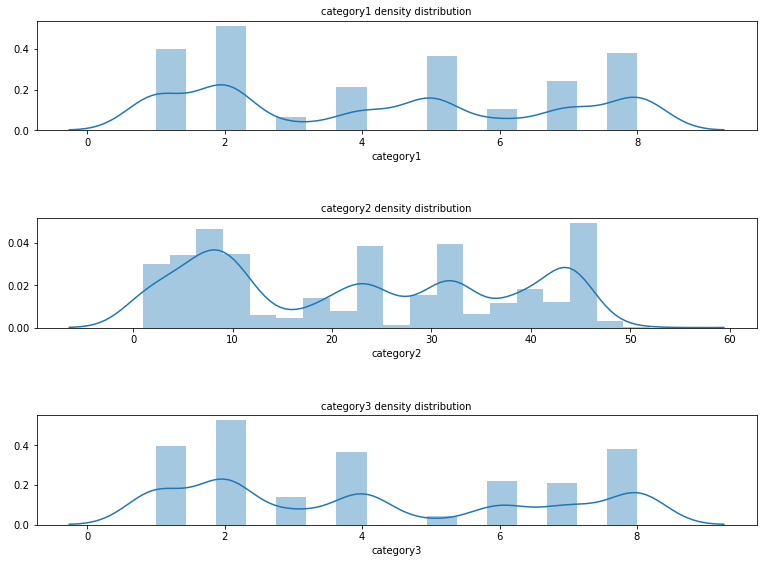

In [16]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    

fig, ax = plt.subplots(3)
plt.subplots_adjust(hspace = 0.8)
sns.distplot(items['category1'].astype('int'), ax=ax[0])
ax[0].set_title('category1 density distribution', fontsize=10)
set_size(10,7)
sns.distplot(items['category2'].astype('int'), ax=ax[1])
ax[1].set_title('category2 density distribution', fontsize=10)
sns.distplot(items['category3'].astype('int'), ax=ax[2])
ax[2].set_title('category3 density distribution', fontsize=10)

In [17]:
# items['category1'].loc[items['category1'] == 3] = 101
# items['category1'].loc[items['category1'] == 6] = 108
# items['category1'].loc[items['category1'] == 4] = 102
# items['category1'].loc[items['category1'] == 7] = 107
# items['category1'].loc[items['category1'] == 5] = 103
# items['category1'].loc[items['category1'] == 8] = 104
# items['category1'].loc[items['category1'] == 2] = 105
# items['category1'].loc[items['category1'] == 1] = 106
# items['category1'] = items['category1'] - 100

In [18]:
# items['category3'].loc[items['category3'] == 3] = 101
# items['category3'].loc[items['category3'] == 5] = 108
# items['category3'].loc[items['category3'] == 6] = 102
# items['category3'].loc[items['category3'] == 7] = 107
# items['category3'].loc[items['category3'] == 1] = 103
# items['category3'].loc[items['category3'] == 4] = 104
# items['category3'].loc[items['category3'] == 2] = 105
# items['category3'].loc[items['category3'] == 8] = 106
# items['category3'] = items['category3'] - 100

#### correlation is getting worse after changing distribution of categories

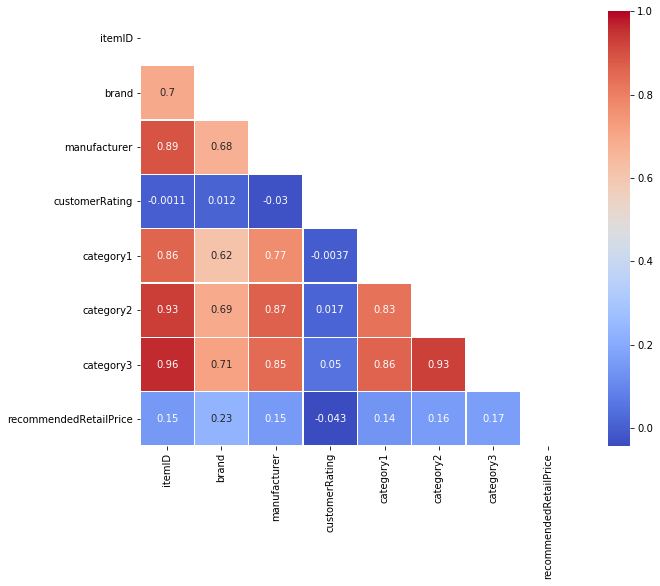

In [19]:
plt.figure(figsize=(12, 8))
mask = np.triu(items.astype('float').corr())
sns.heatmap(items.astype('float').corr(), annot = True, linewidths=.5, cmap='coolwarm', square=True, mask=mask)

#### what procent of transactID reappears?

In [20]:
df = orders['transactID'].value_counts().reset_index()
df.columns = ['index', 'transactID_freq']
print(len(df.loc[df['transactID_freq'] != 1]) / len(df['transactID_freq']), 'Precentage of transactIDs that doesnt reappear')

0.027555482340156815 Precentage of transactIDs that doesnt reappear


#### How big orders are?

In [21]:
orders['order'].value_counts()

1      1791146
2       307746
3        52928
4        16846
5         7491
6         2578
10        1735
8          605
7          433
9          388
15          30
12           7
11           6
13           5
60           4
14           2
100          1
16           1
18           1
30           1
20           1
Name: order, dtype: int64

#### Check if product is on promotion

In [22]:
df = infos['promotion'].value_counts().reset_index()
df.columns = ['index', 'promotion']
print(sum(df.loc[df['index'] != '']['promotion'] / sum(df['promotion'])), 'These precentage of products have been promoted')

0.17614450922297617 These precentage of products have been promoted


#### check pricing behaviour (recommended Retail vs simulation Price)

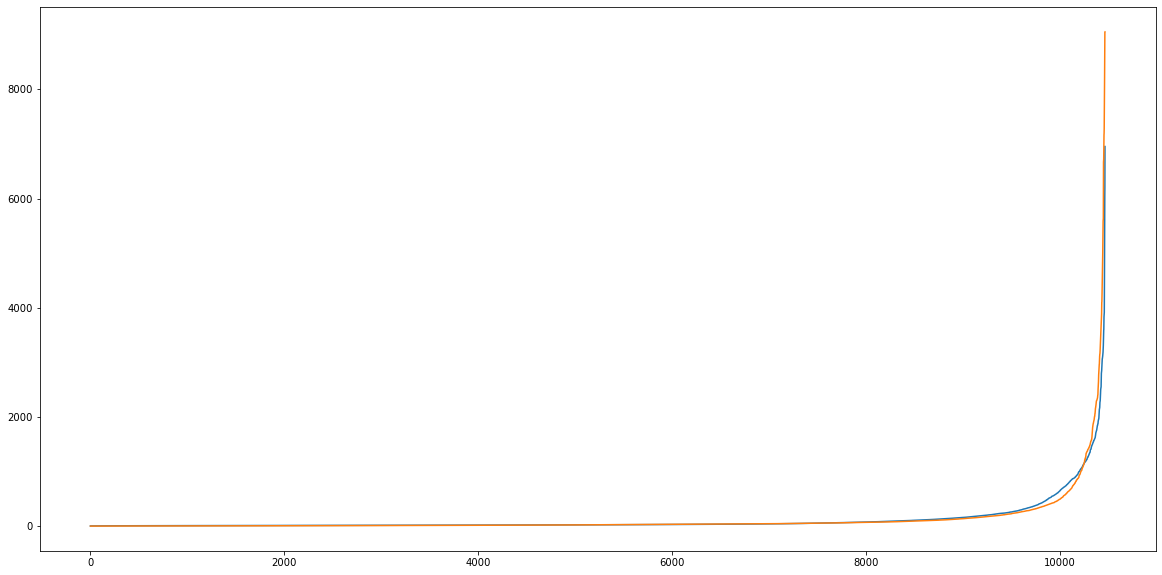

In [23]:
items['recommendedRetailPrice'].astype('float').sort_values().reset_index(drop=True).plot(kind='line', figsize=(20,10))
infos['simulationPrice'].astype('float').sort_values().reset_index(drop=True).plot(kind='line', figsize=(20,10))

#### How to manage promotion value on the past data

In [24]:
keep = infos['promotion']
infos['promotion'] = (infos['promotion'] != '').astype('int')
tmp = orders[['itemID', 'salesPrice']].astype('float').merge(items[['itemID', 'recommendedRetailPrice']].astype('float'), on='itemID', how='left')
tmp = tmp.merge(infos[['itemID', 'simulationPrice', 'promotion']].astype('float'), on='itemID', how='left')
tmp['sales-retail'] = tmp['salesPrice'] - tmp['recommendedRetailPrice']
tmp['simul-retail'] = tmp['simulationPrice'] - tmp['recommendedRetailPrice']
tmp['sales-simul'] = tmp['sales-retail'] - tmp['simul-retail']
infos['promotion'] = keep
tmp

,itemID,salesPrice,recommendedRetailPrice,simulationPrice,promotion,sales-retail,simul-retail,sales-simul
0,450.0,17.42,27.00,17.42,0.0,-9.58,-9.58,0.00
1,83.0,5.19,12.89,5.19,0.0,-7.70,-7.70,0.00
2,7851.0,20.47,11.75,20.47,0.0,8.72,8.72,0.00
3,450.0,17.42,27.00,17.42,0.0,-9.58,-9.58,0.00
4,83.0,5.19,12.89,5.19,0.0,-7.70,-7.70,0.00
...,...,...,...,...,...,...,...,...
2181950,9217.0,23.50,65.49,19.80,0.0,-41.99,-45.69,3.70
2181951,2175.0,11.60,29.01,13.06,0.0,-17.41,-15.95,-1.46
2181952,2061.0,1.03,10.94,1.26,0.0,-9.91,-9.68,-0.23
2181953,2195.0,18.73,35.71,20.16,0.0,-16.98,-15.55,-1.43


In [25]:
promoted = tmp.loc[tmp['promotion'] == 1].reset_index(drop=True)
not_promoted = tmp.loc[tmp['promotion'] == 0].reset_index(drop=True)
print(len(promoted.loc[promoted['sales-simul'] <= 0]) / len(tmp), 'Precentage, Product promoted and salesPrice was lower')
print(len(promoted.loc[promoted['sales-simul'] > 0]) / len(tmp), 'Precentage, Product promoted and salesPrice was higher')
print(len(not_promoted.loc[not_promoted['sales-simul'] < 0]) / len(tmp), 'Precentage, Product not promoted and salesPrice was lower')
print(len(not_promoted.loc[not_promoted['sales-simul'] >= 0]) / len(tmp), 'Precentage, Product not promoted and salesPrice was higher')

0.08236054364090918 Precentage, Product promoted and salesPrice was lower
0.11866514204005124 Precentage, Product promoted and salesPrice was higher
0.11987735769069481 Precentage, Product not promoted and salesPrice was lower
0.6790969566283448 Precentage, Product not promoted and salesPrice was higher


In [26]:
#tmp['sales-retail'].sort_values().reset_index(drop=True).plot(kind='line', figsize=(20,10))
#tmp['simul-retail'].sort_values().reset_index(drop=True).plot(kind='line', figsize=(20,10))

#### number of columns that have the same simulated price

In [27]:
sum(tmp['sales-simul'] == 0) /  len(tmp['sales-simul'])

0.2881099747703321

In [28]:
del df
del mask
del promoted
del not_promoted
del tmp

gc.collect()

112

## Feature Engineering

In [29]:
'''
--- TODO:

items
- change types
- brand and no-brand binning 
- customerRating no-ranked, ranked-low, ranked-high (is 8.7 % high enough? or merge)
- manufacturer, category1,2,3 make noise and normalize  ( combining ? )
- drop recommendedRetailPrice after subtraction operations below 

--- TODO:

orders
- change types
- timedelta from time <present_time - time_bought> normalized
- make time 2 week interval in order to calculate the order values (which is demand) of each product (fill 0 if product is not on the list)
- reapears count of transactID (only 2.7 % reappear) # delete it
- <salesPrice - recommendedRetailPrice> and rescale
- creating additional column (mark the promotion where sales-simul price is < 0 and the product is on the promotion)

--- TODO:

infos
- change types
- delete promotion_start and promotion_end columns (delete promotion after price difference calculation?)
- change promotion column to 0 or 1 dependable of promotion apperance
- <simulation_price - recommendedRetailPrice> and rescale
- create column time_diff ( do sth with it )



--- AT THE END:
- make noise on training
'''

'\n--- TODO:\n\nitems\n- change types\n- brand and no-brand binning \n- customerRating no-ranked, ranked-low, ranked-high (is 8.7 % high enough? or merge)\n- manufacturer, category1,2,3 make noise and normalize  ( combining ? )\n- drop recommendedRetailPrice after subtraction operations below \n\n--- TODO:\n\norders\n- change types\n- timedelta from time <present_time - time_bought> normalized\n- make time 2 week interval in order to calculate the order values (which is demand) of each product (fill 0 if product is not on the list)\n- reapears count of transactID (only 2.7 % reappear) # delete it\n- <salesPrice - recommendedRetailPrice> and rescale\n- creating additional column (mark the promotion where sales-simul price is < 0 and the product is on the promotion)\n\n--- TODO:\n\ninfos\n- change types\n- delete promotion_start and promotion_end columns (delete promotion after price difference calculation?)\n- change promotion column to 0 or 1 dependable of promotion apperance\n- <simul

### Items

#### Change types

In [30]:
items = items.astype('float')

#### brand and no-brand binning 

In [31]:
items['brand'] = items['brand'].apply(lambda value: 1 if value else 0)

#### customerRating ordinal encoding

In [32]:
def score_index(value):
    if (value >= 1) and (value <= 4):
        return -1
    elif value > 4:
        return 1
    else:
        return 0
    
rating = items['customerRating'].apply(score_index)
items['customerRating'] = rating

#### Normalize category and manufacturer features

In [33]:
min_max_scaler = MinMaxScaler()

In [34]:
items['manufacturer'] = min_max_scaler.fit_transform(items[['manufacturer']].values)
items['category1'] = min_max_scaler.fit_transform(items[['category1']].values)
items['category2'] = min_max_scaler.fit_transform(items[['category2']].values)
items['category3'] = min_max_scaler.fit_transform(items[['category3']].values)

In [35]:
items

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1.0,0,0.000000,1,0.0,0.000000,0.0,8.84
1,2.0,0,0.003968,-1,0.0,0.019608,0.0,16.92
2,3.0,0,0.007937,1,0.0,0.039216,0.0,15.89
3,4.0,0,0.003968,1,0.0,0.019608,0.0,40.17
4,5.0,0,0.003968,-1,0.0,0.000000,0.0,17.04
...,...,...,...,...,...,...,...,...
10458,10459.0,1,1.000000,0,1.0,0.843137,1.0,56.57
10459,10460.0,0,1.000000,0,1.0,0.843137,1.0,163.81
10460,10461.0,0,1.000000,0,1.0,0.843137,1.0,128.01
10461,10462.0,1,1.000000,0,1.0,0.843137,1.0,166.97


### Orders

#### Create timedelta intervals ( constants identification )

In [36]:
# intervals starting times ( product restock )
datedict_start = {
    0: datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S'),
    1: datetime.strptime('2018-01-15 00:00:00', '%Y-%m-%d %H:%M:%S'),
    2: datetime.strptime('2018-01-29 00:00:00', '%Y-%m-%d %H:%M:%S'),
    3: datetime.strptime('2018-02-12 00:00:00', '%Y-%m-%d %H:%M:%S'),
    4: datetime.strptime('2018-02-26 00:00:00', '%Y-%m-%d %H:%M:%S'),
    5: datetime.strptime('2018-03-12 00:00:00', '%Y-%m-%d %H:%M:%S'),
    6: datetime.strptime('2018-03-26 00:00:00', '%Y-%m-%d %H:%M:%S'),
    7: datetime.strptime('2018-04-09 00:00:00', '%Y-%m-%d %H:%M:%S'),
    8: datetime.strptime('2018-04-23 00:00:00', '%Y-%m-%d %H:%M:%S'),
    9: datetime.strptime('2018-05-07 00:00:00', '%Y-%m-%d %H:%M:%S'),
    10: datetime.strptime('2018-05-21 00:00:00', '%Y-%m-%d %H:%M:%S'),
    11: datetime.strptime('2018-06-04 00:00:00', '%Y-%m-%d %H:%M:%S'),
    12: datetime.strptime('2018-06-18 00:00:00', '%Y-%m-%d %H:%M:%S')
}

# intervals ending times ( product restock )
datedict_end = {
    0: datetime.strptime('2018-01-14 23:59:59', '%Y-%m-%d %H:%M:%S'),
    1: datetime.strptime('2018-01-28 23:59:59', '%Y-%m-%d %H:%M:%S'),
    2: datetime.strptime('2018-02-11 23:59:59', '%Y-%m-%d %H:%M:%S'),
    3: datetime.strptime('2018-02-25 23:59:59', '%Y-%m-%d %H:%M:%S'),
    4: datetime.strptime('2018-03-11 23:59:59', '%Y-%m-%d %H:%M:%S'),
    5: datetime.strptime('2018-03-25 23:59:59', '%Y-%m-%d %H:%M:%S'),
    6: datetime.strptime('2018-04-08 23:59:59', '%Y-%m-%d %H:%M:%S'),
    7: datetime.strptime('2018-04-22 23:59:59', '%Y-%m-%d %H:%M:%S'),
    8: datetime.strptime('2018-05-06 23:59:59', '%Y-%m-%d %H:%M:%S'),
    9: datetime.strptime('2018-05-20 23:59:59', '%Y-%m-%d %H:%M:%S'),
    10: datetime.strptime('2018-06-03 23:59:59', '%Y-%m-%d %H:%M:%S'),
    11: datetime.strptime('2018-06-17 23:59:59', '%Y-%m-%d %H:%M:%S'),
    12: datetime.strptime('2018-06-29 23:59:59', '%Y-%m-%d %H:%M:%S'),
}

# first date in a test set (teoretically)
first_date = datetime.strptime('2018-06-30 00:00:00', '%Y-%m-%d %H:%M:%S')

# max time for a given interval
max_time = [((first_date - datedict_start[interval]).days * 86400 + (first_date - datedict_start[interval]).seconds) for interval in range(13)]

# min time for a given interval
min_time = [((first_date - datedict_end[interval]).days * 86400 + (first_date - datedict_end[interval]).seconds) for interval in range(13)]    

#### Constants checking

In [37]:
for i in range(13):
    print((datedict_end[i] - datedict_start[i]).days * 86400 + (datedict_end[i] - datedict_start[i]).seconds)

1209599
1209599
1209599
1209599
1209599
1209599
1209599
1209599
1209599
1209599
1209599
1209599
1036799


#### Convert time column and get interval from it

In [38]:
def dt_conversion(value):
    diff = datetime.strptime(value, '%Y-%m-%d %H:%M:%S')
    diff = ((first_date - diff).days * 86400 + (first_date - diff).seconds)
    return diff

time_diff = orders['time'].apply(dt_conversion)
orders['time_diff'] = time_diff

In [39]:
def get_interval(value):
    for interval in range(13):
        if (value < max_time[interval]) and (value > min_time[interval]):
            return interval
    return -1

interval = time_diff.apply(get_interval)
orders['interval'] = interval

#### Frequency of a given intervals

In [40]:
interval.value_counts()

10    225249
8     214899
11    208427
12    207642
4     206874
7     199830
5     184589
9     180852
6     173363
3     131893
1      92149
2      81222
0      74966
Name: time, dtype: int64

#### Drop transactID and time column

In [41]:
orders.drop(['time', 'transactID'], axis=1, inplace=True)

#### Change types

In [42]:
orders = orders.astype('float')

#### Merge with items dataframe

In [43]:
orders = orders.merge(items, on='itemID')

#### calculate price_diff for orders and drop redundant columns

In [44]:
orders['price_diff'] = orders['salesPrice'] - orders['recommendedRetailPrice']
orders.drop(['salesPrice', 'recommendedRetailPrice'], axis=1, inplace=True)

#### Rescale time_diff

In [45]:
min_max_scaler = MinMaxScaler(feature_range=(-0.86, 1))

In [46]:
orders['time_diff'] = min_max_scaler.fit_transform(orders[['time_diff']].values) * (-1)

### Infos

#### Delete promotion_start and promotion_end columns ( too disinformative )

In [47]:
infos.drop(['promotion_start', 'promotion_end'], axis=1, inplace=True)

#### change promotion column to 0 or 1 dependable of promotion apperance

In [48]:
infos['promotion'] = (infos['promotion'] != '').astype('int')

#### Change types

In [49]:
infos = infos.astype('float')

#### Merge with items dataframe

In [50]:
infos = infos.merge(items, on='itemID')

#### Calculate price difference and drop redundant columns

In [51]:
infos['price_diff'] = infos['simulationPrice'] - infos['recommendedRetailPrice']
infos.drop(['simulationPrice', 'recommendedRetailPrice'], axis=1, inplace=True)

#### Create and rescale time_diff 

In [52]:
infos['time_diff'] = np.random.random_sample(size=infos.shape[0])
min_max_scaler = MinMaxScaler(feature_range=(0.82, 0.96))
infos['time_diff'] = min_max_scaler.fit_transform(infos[['time_diff']].values)

## Modeling

#### Create X_train set

In [53]:
X_train = {}
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

In [54]:
for interval in range(13):
    #merge with items
    data = items.merge(orders[orders['interval'] == interval], on=['itemID', 'brand', 'manufacturer', 'customerRating', 'category1', 'category2', 'category3'], how='left')
    data.drop(['interval', 'order'], axis=1, inplace=True)
    
    # get frame by item (shape reduction)
    data = data.groupby('itemID').mean().reset_index()
    
    # calculate time_diff by random at specified interval
    data['time_diff'] = data['time_diff'].fillna(pd.Series(np.random.uniform(low=((-1) + (0.14 * interval)), high=((-1) + (0.14 * (interval+1))), size=data.shape[0])))
    
    # set promotion column
    data['promotion'] = 0
    data = data.merge(infos[['itemID', 'price_diff', 'promotion']], on='itemID')
    save = data[(data['promotion_y'] == 0) & (data['price_diff_x'] <= data['price_diff_y'])]['itemID']
    data['promotion_x'].loc[~data['itemID'].isin(save)] = np.random.choice([0, 1], size=(len(data['promotion_x']) - len(save)), p=[0.90, 0.1])
    data['promotion_x'].loc[data['itemID'].isin(data[(data['promotion_y'] == 1) & (data['price_diff_x'] >= data['price_diff_y'])]['itemID'])] = 1
    
    # assign unknown price diff and rescale
    data['price_diff_x'] = data['price_diff_x'].fillna(data['recommendedRetailPrice'] * (-1))
    data['price_diff_x'] = min_max_scaler.fit_transform(data[['price_diff_x']].values)
    
    # drop redundant columns, and rename aftermerge columns
    data.drop(['itemID','recommendedRetailPrice', 'price_diff_y', 'promotion_y'], axis=1, inplace=True) #'itemID', 
    data.rename(columns={'price_diff_x': 'price_diff', 'promotion_x':'promotion'}, inplace=True)
    
    # make noise
#     data['manufacturer'] = data['manufacturer'] + np.random.uniform(low=-0.0001, high=0.0001, size=data.shape[0])
#     data['category1'] = data['category1'] + np.random.uniform(low=-0.01, high=0.01, size=data.shape[0])
#     data['category2'] = data['category2'] + np.random.uniform(low=-0.001, high=0.001, size=data.shape[0])
#     data['category3'] = data['category3'] + np.random.uniform(low=-0.01, high=0.01, size=data.shape[0])
#     data['price_diff'] = data['price_diff'] + np.random.uniform(low=-0.0001, high=0.0001, size=data.shape[0])
    
#     data['manufacturer'] = min_max_scaler.fit_transform(data[['manufacturer']].values)
#     data['category1'] = min_max_scaler.fit_transform(data[['category1']].values)
#     data['category2'] = min_max_scaler.fit_transform(data[['category2']].values)
#     data['category3'] = min_max_scaler.fit_transform(data[['category3']].values)    
    
    # assign to training set part
    X_train[interval] = data
    

In [55]:
X_train[0]

,brand,manufacturer,customerRating,category1,category2,category3,time_diff,price_diff,promotion
0,0,0.000000,1,0.0,0.000000,0.0,-0.878523,0.311116,0
1,0,0.003968,-1,0.0,0.019608,0.0,-0.892498,0.309591,0
2,0,0.007937,1,0.0,0.039216,0.0,-0.903560,0.312435,0
3,0,0.003968,1,0.0,0.019608,0.0,-0.863931,0.305202,1
4,0,0.003968,-1,0.0,0.000000,0.0,-0.936522,0.311048,0
...,...,...,...,...,...,...,...,...,...
10458,1,1.000000,0,1.0,0.843137,1.0,-0.950957,0.302106,0
10459,0,1.000000,0,1.0,0.843137,1.0,-0.928287,0.281865,0
10460,0,1.000000,0,1.0,0.843137,1.0,-0.959371,0.288622,0
10461,1,1.000000,0,1.0,0.843137,1.0,-0.958259,0.281268,0


In [56]:
#X_train[0]['category1'].value_counts().head(30)

#### Create y_train set

In [57]:
y_train = {}

for interval in range(13):
    labels = orders[orders['interval'] == interval].groupby('itemID').sum()['order'].reset_index()
    labels = pd.DataFrame(items['itemID']).merge(labels, on=['itemID'], how='left').fillna(0)
    
    #labels.drop(labels.tail(1).index, inplace=True)
    labels.drop('itemID', axis=1, inplace=True)
    
    y_train[interval] = labels

In [58]:
#y_train[12].loc[y_train[12]['order'] > 0]
y_train[0]

,order
0,0.0
1,0.0
2,1.0
3,0.0
4,2.0
...,...
10458,0.0
10459,0.0
10460,0.0
10461,0.0


#### Create X_test set

In [59]:
infos['price_diff'] = min_max_scaler.fit_transform(infos[['price_diff']].values)
infos = infos[['itemID', 'brand', 'manufacturer', 'customerRating', 'category1', 'category2', 'category3', 'time_diff', 'price_diff', 'promotion']]
X_test = infos.drop('itemID', axis=1)

In [60]:
X_test

,brand,manufacturer,customerRating,category1,category2,category3,time_diff,price_diff,promotion
0,0,0.000000,1,0.0,0.000000,0.0,0.877140,-0.305344,0.0
1,0,0.003968,-1,0.0,0.019608,0.0,0.872017,-0.305976,0.0
2,0,0.007937,1,0.0,0.039216,0.0,0.838846,-0.304389,0.0
3,0,0.003968,1,0.0,0.019608,0.0,0.912741,-0.310882,0.0
4,0,0.003968,-1,0.0,0.000000,0.0,0.835257,-0.306456,0.0
...,...,...,...,...,...,...,...,...,...
10458,1,1.000000,0,1.0,0.843137,1.0,0.863836,-0.315116,0.0
10459,0,1.000000,0,1.0,0.843137,1.0,0.870785,-0.260500,0.0
10460,0,1.000000,0,1.0,0.843137,1.0,0.931075,-0.287132,0.0
10461,1,1.000000,0,1.0,0.843137,1.0,0.855843,-0.267076,0.0


### Setup

In [61]:
data = pd.DataFrame()

for interval in range(13):
    connected = pd.concat([X_train[interval], y_train[interval]], axis=1)
    data = pd.concat([data, connected], axis=0)
    
# data['brand'] = data['brand'].astype('int')
# data['order'] = data['order'].astype('int')

In [62]:
data

,brand,manufacturer,customerRating,category1,category2,category3,time_diff,price_diff,promotion,order
0,0,0.000000,1,0.0,0.000000,0.0,-0.878523,0.311116,0,0.0
1,0,0.003968,-1,0.0,0.019608,0.0,-0.892498,0.309591,0,0.0
2,0,0.007937,1,0.0,0.039216,0.0,-0.903560,0.312435,0,1.0
3,0,0.003968,1,0.0,0.019608,0.0,-0.863931,0.305202,1,0.0
4,0,0.003968,-1,0.0,0.000000,0.0,-0.936522,0.311048,0,2.0
...,...,...,...,...,...,...,...,...,...,...
10458,1,1.000000,0,1.0,0.843137,1.0,0.793608,0.482422,0,0.0
10459,0,1.000000,0,1.0,0.843137,1.0,0.684225,0.459377,0,0.0
10460,0,1.000000,0,1.0,0.843137,1.0,0.724696,0.467070,0,0.0
10461,1,1.000000,0,1.0,0.843137,1.0,0.759095,0.458698,0,0.0


In [74]:
reg = setup(data = data, target = 'order', train_size=(0.92307692317), transformation=True, feature_ratio=True,
           group_features=['manufacturer', 'category1', 'category2', 'category3'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,3807
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(136019, 10)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,3
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


### Choosing and Creating ML model

In [75]:
#compare_models(turbo=True, blacklist=['ransac'], fold=13)

In [76]:
lightgbm = create_model('lightgbm', fold=13)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.7066,1024.6414,32.0100,0.9078,1.3552,3.6673
1,10.2644,1513.7793,38.9073,0.8398,1.3707,3.5430
2,10.3769,1379.8253,37.1460,0.8652,1.3517,3.5199
3,10.4085,1565.6146,39.5678,0.8413,1.3672,3.5495
4,11.0065,3241.2352,56.9318,0.7795,1.3703,3.4288
5,10.7757,3171.1099,56.3126,0.7575,1.3610,3.7842
6,10.3167,1274.2059,35.6960,0.8903,1.3800,3.8435
7,10.1274,1547.8894,39.3432,0.8344,1.3626,3.6527
8,10.4979,2929.7570,54.1272,0.7406,1.3651,3.6049
9,9.9316,1316.9001,36.2891,0.8738,1.3664,3.6094


In [77]:
finalize_model(lightgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=3807, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [78]:
predict_model(lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,9.7042,1061.1287,32.575,0.897,1.3548,3.8087


,manufacturer,category1,category2,category3,time_diff,price_diff,group_0_Min,group_0_Max,group_0_Mean,group_0_Mode,...,customerRating_1,promotion_1,category3_divide_category1,time_diff_divide_category1,price_diff_divide_group_0_Mean,group_0_Std_divide_category1,category3_divide_group_0_Max,category1_divide_category2,order,Label
0,-0.315797,-0.862925,-0.974102,-0.799243,-1.126000,-0.722393,-0.636652,-0.687876,-0.796194,-0.616720,...,0.0,0.0,0.926202,1.304863,0.907309,-0.044738,1.161901,0.885867,0.0,-3.2791
1,-0.034897,1.079031,0.313052,0.830811,0.045449,-0.898677,0.554528,0.871805,0.607575,0.473955,...,1.0,0.0,0.769960,0.042121,-1.479123,1.154575,0.952978,3.446810,0.0,-0.4452
2,0.670722,0.403707,0.686340,0.128016,0.469024,-0.518514,0.581136,0.220868,0.437535,0.497611,...,0.0,0.0,0.317101,1.161795,-1.185081,-0.020423,0.579604,0.588202,0.0,0.8132
3,-0.994745,0.021780,-0.512562,-0.799243,0.003961,-0.019377,-0.607429,-0.426392,-0.602535,-0.616720,...,0.0,0.0,-36.695498,0.181856,0.032159,24.145913,1.874434,-0.042493,2.0,13.9755
4,-0.315797,-0.862925,-0.974102,-0.799243,-0.771429,0.035569,-0.636652,-0.687876,-0.796194,-0.616720,...,0.0,0.0,0.926202,0.893970,-0.044674,-0.044738,1.161901,0.885867,0.0,0.1911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10458,0.004233,0.754512,-0.154313,-0.300269,-1.375184,0.738025,0.052356,0.426861,0.073563,0.016175,...,0.0,0.0,-0.397965,-1.822613,10.032521,1.495996,-0.703436,-4.889495,0.0,-1.0598
10459,-0.127147,0.403707,-0.016956,0.128016,-1.448520,0.896080,0.456574,-0.006112,0.073191,0.386341,...,0.0,0.0,0.317101,-3.588052,12.242957,-0.421371,-20.944126,-23.809716,0.0,-2.2803
10460,-1.260343,-1.386057,-1.564924,-1.391875,-1.443128,0.905192,-1.454005,-1.384193,-1.441284,-1.477989,...,0.0,1.0,1.004197,1.041176,-0.628046,0.718159,1.005549,0.885702,0.0,7.7353
10461,-1.538430,-1.386057,-1.304049,-1.391875,-0.440923,0.798456,-1.454005,-1.448787,-1.449958,-1.477989,...,1.0,0.0,1.004197,0.318113,-0.550675,0.943228,0.960717,1.062887,75.0,9.9836


### Model Tuning

In [79]:
tuned_lgbm = tune_model('lightgbm', fold=13, n_iter = 50, optimize = 'r2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.9865,935.2531,30.5819,0.9159,1.2220,3.7421
1,9.1440,1174.3086,34.2682,0.8757,1.1801,3.6494
2,9.3948,1108.4205,33.2930,0.8917,1.2162,3.6595
3,9.4018,1361.2957,36.8957,0.8620,1.2167,3.7109
4,9.9428,2731.5101,52.2639,0.8142,1.1967,3.5412
5,9.8866,2714.4509,52.1004,0.7924,1.1913,3.6775
6,9.1121,962.5560,31.0251,0.9172,1.2035,3.6517
7,8.9915,1144.2080,33.8261,0.8776,1.1917,3.6052
8,9.2374,2151.8413,46.3879,0.8095,1.2130,3.5592
9,8.8949,1094.3355,33.0807,0.8951,1.1775,3.3613


In [80]:
finalize_model(tuned_lgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
              n_estimators=150, n_jobs=-1, num_leaves=40, objective=None,
              random_state=3807, reg_alpha=0.1, reg_lambda=0.9, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [81]:
predict_model(tuned_lgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8.8563,922.9291,30.3797,0.9104,1.1842,3.6409


,manufacturer,category1,category2,category3,time_diff,price_diff,group_0_Min,group_0_Max,group_0_Mean,group_0_Mode,...,customerRating_1,promotion_1,category3_divide_category1,time_diff_divide_category1,price_diff_divide_group_0_Mean,group_0_Std_divide_category1,category3_divide_group_0_Max,category1_divide_category2,order,Label
0,-0.315797,-0.862925,-0.974102,-0.799243,-1.126000,-0.722393,-0.636652,-0.687876,-0.796194,-0.616720,...,0.0,0.0,0.926202,1.304863,0.907309,-0.044738,1.161901,0.885867,0.0,-0.5408
1,-0.034897,1.079031,0.313052,0.830811,0.045449,-0.898677,0.554528,0.871805,0.607575,0.473955,...,1.0,0.0,0.769960,0.042121,-1.479123,1.154575,0.952978,3.446810,0.0,-2.3739
2,0.670722,0.403707,0.686340,0.128016,0.469024,-0.518514,0.581136,0.220868,0.437535,0.497611,...,0.0,0.0,0.317101,1.161795,-1.185081,-0.020423,0.579604,0.588202,0.0,0.5981
3,-0.994745,0.021780,-0.512562,-0.799243,0.003961,-0.019377,-0.607429,-0.426392,-0.602535,-0.616720,...,0.0,0.0,-36.695498,0.181856,0.032159,24.145913,1.874434,-0.042493,2.0,17.9068
4,-0.315797,-0.862925,-0.974102,-0.799243,-0.771429,0.035569,-0.636652,-0.687876,-0.796194,-0.616720,...,0.0,0.0,0.926202,0.893970,-0.044674,-0.044738,1.161901,0.885867,0.0,-1.0827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10458,0.004233,0.754512,-0.154313,-0.300269,-1.375184,0.738025,0.052356,0.426861,0.073563,0.016175,...,0.0,0.0,-0.397965,-1.822613,10.032521,1.495996,-0.703436,-4.889495,0.0,-1.0770
10459,-0.127147,0.403707,-0.016956,0.128016,-1.448520,0.896080,0.456574,-0.006112,0.073191,0.386341,...,0.0,0.0,0.317101,-3.588052,12.242957,-0.421371,-20.944126,-23.809716,0.0,-3.1212
10460,-1.260343,-1.386057,-1.564924,-1.391875,-1.443128,0.905192,-1.454005,-1.384193,-1.441284,-1.477989,...,0.0,1.0,1.004197,1.041176,-0.628046,0.718159,1.005549,0.885702,0.0,21.9947
10461,-1.538430,-1.386057,-1.304049,-1.391875,-0.440923,0.798456,-1.454005,-1.448787,-1.449958,-1.477989,...,1.0,0.0,1.004197,0.318113,-0.550675,0.943228,0.960717,1.062887,75.0,8.8649


### Ensemble

In [82]:
boosted_lgbm = ensemble_model(tuned_lgbm, fold=13, method = 'Boosting', n_estimators=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.8144,502.3870,22.4140,0.9548,1.4477,4.7511
1,9.0025,679.6894,26.0709,0.9281,1.4307,4.7633
2,9.1019,602.5020,24.5459,0.9411,1.4352,4.4930
3,9.3066,928.9502,30.4787,0.9058,1.4423,4.7039
4,9.7553,2308.8744,48.0507,0.8429,1.4251,4.4590
5,9.7839,2400.6381,48.9963,0.8164,1.4346,4.8021
6,8.9498,818.5321,28.6100,0.9296,1.3971,4.7284
7,8.7903,792.5098,28.1516,0.9152,1.3891,4.4284
8,9.4122,2059.3049,45.3796,0.8177,1.4549,4.5379
9,9.1453,723.2411,26.8931,0.9307,1.4517,4.4357


In [83]:
predict_model(boosted_lgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ada Boost Regressor,8.9117,578.7553,24.0573,0.9438,1.4521,4.7542


,manufacturer,category1,category2,category3,time_diff,price_diff,group_0_Min,group_0_Max,group_0_Mean,group_0_Mode,...,customerRating_1,promotion_1,category3_divide_category1,time_diff_divide_category1,price_diff_divide_group_0_Mean,group_0_Std_divide_category1,category3_divide_group_0_Max,category1_divide_category2,order,Label
0,-0.315797,-0.862925,-0.974102,-0.799243,-1.126000,-0.722393,-0.636652,-0.687876,-0.796194,-0.616720,...,0.0,0.0,0.926202,1.304863,0.907309,-0.044738,1.161901,0.885867,0.0,-1.5623
1,-0.034897,1.079031,0.313052,0.830811,0.045449,-0.898677,0.554528,0.871805,0.607575,0.473955,...,1.0,0.0,0.769960,0.042121,-1.479123,1.154575,0.952978,3.446810,0.0,-3.4372
2,0.670722,0.403707,0.686340,0.128016,0.469024,-0.518514,0.581136,0.220868,0.437535,0.497611,...,0.0,0.0,0.317101,1.161795,-1.185081,-0.020423,0.579604,0.588202,0.0,-0.3006
3,-0.994745,0.021780,-0.512562,-0.799243,0.003961,-0.019377,-0.607429,-0.426392,-0.602535,-0.616720,...,0.0,0.0,-36.695498,0.181856,0.032159,24.145913,1.874434,-0.042493,2.0,16.4850
4,-0.315797,-0.862925,-0.974102,-0.799243,-0.771429,0.035569,-0.636652,-0.687876,-0.796194,-0.616720,...,0.0,0.0,0.926202,0.893970,-0.044674,-0.044738,1.161901,0.885867,0.0,-2.1930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10458,0.004233,0.754512,-0.154313,-0.300269,-1.375184,0.738025,0.052356,0.426861,0.073563,0.016175,...,0.0,0.0,-0.397965,-1.822613,10.032521,1.495996,-0.703436,-4.889495,0.0,-3.8029
10459,-0.127147,0.403707,-0.016956,0.128016,-1.448520,0.896080,0.456574,-0.006112,0.073191,0.386341,...,0.0,0.0,0.317101,-3.588052,12.242957,-0.421371,-20.944126,-23.809716,0.0,0.1398
10460,-1.260343,-1.386057,-1.564924,-1.391875,-1.443128,0.905192,-1.454005,-1.384193,-1.441284,-1.477989,...,0.0,1.0,1.004197,1.041176,-0.628046,0.718159,1.005549,0.885702,0.0,2.8495
10461,-1.538430,-1.386057,-1.304049,-1.391875,-0.440923,0.798456,-1.454005,-1.448787,-1.449958,-1.477989,...,1.0,0.0,1.004197,0.318113,-0.550675,0.943228,0.960717,1.062887,75.0,43.8407


## Evaluation

### Model Summary

In [84]:
final_model = finalize_model(boosted_lgbm)
final_model

AdaBoostRegressor(base_estimator=LGBMRegressor(boosting_type='gbdt',
                                               class_weight=None,
                                               colsample_bytree=1.0,
                                               importance_type='split',
                                               learning_rate=0.5, max_depth=10,
                                               min_child_samples=20,
                                               min_child_weight=0.001,
                                               min_split_gain=0,
                                               n_estimators=150, n_jobs=-1,
                                               num_leaves=40, objective=None,
                                               random_state=3807, reg_alpha=0.1,
                                               reg_lambda=0.9, silent=True,
                                               subsample=1.0,
                                               subsample_for_bin=2

### Prediction

In [85]:
predictions = predict_model(boosted_lgbm, data=X_test)

## Feedback

### Performance

In [86]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Reasoning on observations

In [ ]:
#interpret_model(stacker, plot='reason')

## Deployment

### Round the scores

In [87]:
def normal_round(n):
    if n > 0:
        #if n - math.floor(n) < 0.5:
        return math.floor(n)
        #return math.ceil(n)
    else:
        return 0

predictions = predictions['Label']
predictions = predictions.apply(normal_round)

### Results verification

In [88]:
sorted(predictions, reverse=True)

[104,
 82,
 80,
 69,
 67,
 66,
 65,
 63,
 62,
 62,
 62,
 62,
 62,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 58,
 58,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 56,
 56,
 56,
 56,
 56,
 55,
 55,
 54,
 54,
 53,
 53,
 53,
 53,
 53,
 53,
 52,
 52,
 52,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,

In [89]:
predictions.loc[predictions > 0]

0        27
7         7
10        2
13       28
24        8
         ..
10458    28
10459    27
10460    27
10461    28
10462    27
Name: Label, Length: 5643, dtype: int64

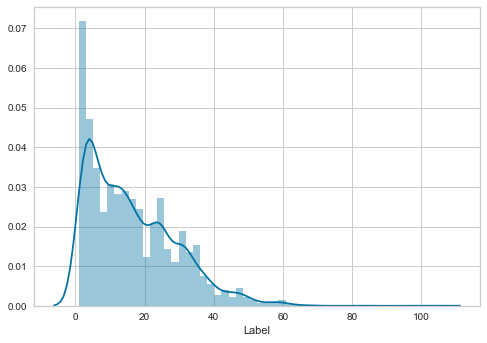

In [90]:
sns.distplot(predictions.loc[predictions > 0])

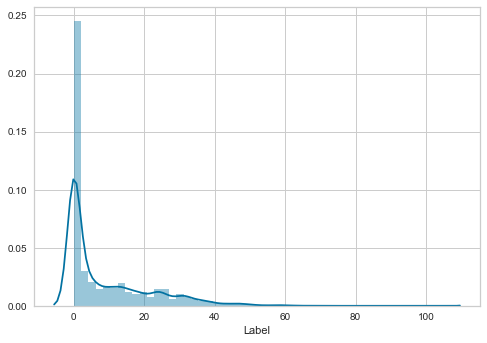

In [91]:
sns.distplot(predictions)

### Submission

In [92]:
submission = pd.concat([items['itemID'], predictions], axis=1)
submission.columns = ['itemID', 'demandPrediction']
submission['itemID'] = submission['itemID'].astype('int')
submission = submission.astype('str')

In [93]:
submission = submission['itemID'].str.cat(submission['demandPrediction'], sep='|')
submission.columns = ['itemID|demandPrediction']
pd.DataFrame(submission)

,itemID
0,1|27
1,2|0
2,3|0
3,4|0
4,5|0
...,...
10458,10459|28
10459,10460|27
10460,10461|27
10461,10462|28


In [94]:
pd.DataFrame(submission).to_csv('submission3.csv', index=False)